In [1]:
#@title Importing All Libraries
import os
import gc
import torch
import torchaudio
import torchvision
import numpy as np
import torch.nn as nn
from torchvision import *
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
#@title Mounting Drive
from google.colab import drive
drive.mount('/content/Drive')

Mounted at /content/Drive


In [3]:
#@title Listing All Libraries
lst = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

In [4]:
#@title Function Defination to Plot Spectrogram
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
   waveform = waveform.numpy()
   num_channels, num_frames = waveform.shape
   figure, axes = plt.subplots(num_channels, 1)
   if num_channels == 1:
       axes = [axes]
   for c in range(num_channels):
       axes[c].specgram(waveform[c], Fs=sample_rate)
       if num_channels > 1:
           axes[c].set_ylabel(f"Channel {c+1}")
       if xlim:
           axes[c].set_xlim(xlim)
   plt.xticks([]), plt.yticks([])

In [5]:
#@title Making Training and Testing Directories to Store Spectrogram
os.mkdir('/content/Train_image')
for i in range(0,10):
  os.mkdir('/content/Train_image/' + lst[i])

os.mkdir('/content/Test_image')
for i in range(0,10):
  os.mkdir('/content/Test_image/' + lst[i])

In [6]:
#@title Plotting Training Spectrograms
for i in range(0,10):
  
  dir_path = '/content/Drive/MyDrive/GTZAN_audio/' + lst[i]
  lst1 = os.listdir(dir_path)
  os.chdir('/content/Train_image/' + lst[i])

  for j in range(0,90):
    path = dir_path + '/' + lst1[j]

    if path != '/content/Drive/MyDrive/GTZAN_audio/jazz/jazz.00054.wav':

      waveform , sample_rate = torchaudio.load(path)

      plot_specgram(waveform, sample_rate, lst1[j])
      plt.savefig(lst1[j] + '.png')
      plt.close()

    else:
      pass

gc.collect()

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


0

In [7]:
#@title Plotting Testing Spectrograms
for i in range(0,10):
  
  dir_path = '/content/Drive/MyDrive/GTZAN_audio/' + lst[i]
  lst1 = os.listdir(dir_path)
  os.chdir('/content/Test_image/' + lst[i])

  for j in range(90,100):
    path = dir_path + '/' + lst1[j]

    if path != '/content/Drive/MyDrive/GTZAN_audio/jazz/jazz.00054.wav':

      waveform , sample_rate = torchaudio.load(path)

      plot_specgram(waveform, sample_rate, lst1[j])
      plt.savefig(lst1[j] + '.png')
      plt.close()

    else:
      pass

gc.collect()

1464471

In [8]:
#@title Loading Dataset to Normalise Dataset
transform = transforms.Compose([transforms.ToTensor()])
data_set = torchvision.datasets.ImageFolder('/content/Train_image', transform = transform)
data = DataLoader(data_set, batch_size = 1000, shuffle = True)

In [9]:
#@title Calculating Mean and Standard Deviation
mean = 0
std = 0
for k, (images, labels) in enumerate(data):
  mean += torch.mean(images)
  std += torch.std(images)

mean = mean/(k+1)
std = std/(k+1)

In [10]:
#@title Deleting Previous Datasets
del data_set
del data

In [11]:
#@title Loading Normalised Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std), transforms.Resize((144,144))])
data_set = torchvision.datasets.ImageFolder('/content/Train_image', transform = transform)
data = DataLoader(data_set, batch_size = 100, shuffle = True)

In [12]:
#@title Selecting Device
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print(f"Using {device} device")

Using cuda:0 device


In [13]:
#@title Checking Image Dimensions
img = mpimg.imread('/content/Train_image/blues/blues.00027.wav.png')
print(img.shape)

(288, 432, 4)


In [14]:
#@title Defining Neural Network Class
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    self.L1 = nn.Sequential(
        nn.Conv2d(3, 15, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(15),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        #nn.Dropout(0.1)
    )
    self.L2 = nn.Sequential(
        nn.Conv2d(15, 45, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(45),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        #nn.Dropout(0.3)
    )
    self.L3 = nn.Sequential(
        nn.Conv2d(45, 75, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(75),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        #nn.Dropout(0.1)
    )
    self.L4 = nn.Linear(18*18*75, 5000)
    self.L5 = nn.Linear(5000, 500)
    self.L6 = nn.Linear(500, 100)
    self.L7 = nn.Linear(100, 10)

  def forward(self, x):
    out = self.L1(x)
    out = self.L2(out)
    out = self.L3(out)
    out = out.reshape(out.size(0), -1)
    out = self.L4(out)
    out = F.relu(out)
    out = self.L5(out)
    out = F.relu(out)
    out = self.L6(out)
    out = F.relu(out)
    out = self.L7(out)
    out = F.log_softmax(out, dim=1)
    return out

In [15]:
#@title Creating a Neural Network Object
NeuralNet = Net()
NeuralNet = NeuralNet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(NeuralNet.parameters(), lr=5e-4,betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

In [16]:
#@title Training Neural Network
loss_func = []
accuracy = []

for i in range(0,100):
  torch.cuda.empty_cache()
  gc.collect()
  for k, (images,labels) in enumerate(data):
    images = images.to(device)
    labels = labels.to(device)
    output = NeuralNet(images)
    loss = criterion(output, labels)
    loss_func.append(float(loss))
    total = labels.size(0)
    _, predicted = torch.max(output.data , 1)
    correct = (predicted == labels).sum().item()
    acc = correct*100/total
    accuracy.append(acc)
    if k%10 == 0:
      print(loss)
      print(acc)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

tensor(2.3086, device='cuda:0', grad_fn=<NllLossBackward0>)
8.0
tensor(2.2118, device='cuda:0', grad_fn=<NllLossBackward0>)
21.0
tensor(2.0404, device='cuda:0', grad_fn=<NllLossBackward0>)
25.0
tensor(2.0050, device='cuda:0', grad_fn=<NllLossBackward0>)
27.0
tensor(1.9788, device='cuda:0', grad_fn=<NllLossBackward0>)
26.0
tensor(1.9133, device='cuda:0', grad_fn=<NllLossBackward0>)
23.0
tensor(1.7783, device='cuda:0', grad_fn=<NllLossBackward0>)
31.0
tensor(1.6520, device='cuda:0', grad_fn=<NllLossBackward0>)
36.0
tensor(1.4155, device='cuda:0', grad_fn=<NllLossBackward0>)
49.0
tensor(1.3525, device='cuda:0', grad_fn=<NllLossBackward0>)
50.0
tensor(1.4193, device='cuda:0', grad_fn=<NllLossBackward0>)
44.0
tensor(1.2949, device='cuda:0', grad_fn=<NllLossBackward0>)
55.0
tensor(1.0480, device='cuda:0', grad_fn=<NllLossBackward0>)
60.0
tensor(1.3880, device='cuda:0', grad_fn=<NllLossBackward0>)
45.0
tensor(1.0904, device='cuda:0', grad_fn=<NllLossBackward0>)
56.0
tensor(0.9858, device='cud

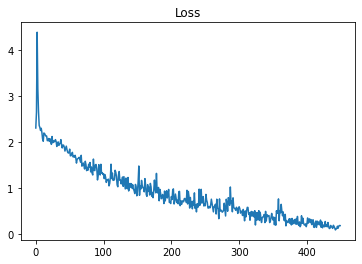

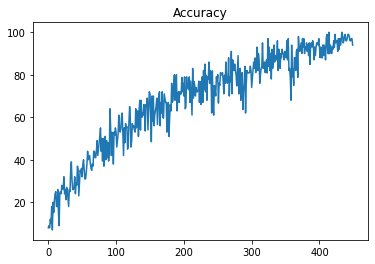

In [17]:
#@title Plotting Loss And Accuracy of the Neural Network
plt.plot(loss_func)
plt.title("Loss")
plt.show()
plt.plot(accuracy)
plt.title("Accuracy")
plt.show()

In [18]:
#@title Loading Test Dataset
trans = transforms.Compose([transforms.ToTensor(), transforms.Resize((144,144))])
test_set = torchvision.datasets.ImageFolder('/content/Test_image', transform = trans)
test = DataLoader(test_set, batch_size = 100, shuffle = True)

In [19]:
#@title Checking Test Accuracy
for k, (img,lab) in enumerate(test):
    img = img.to(device)
    lab = lab.to(device)
    output = NeuralNet(img)
    loss = criterion(output, lab)
    total = lab.size(0)
    _, predicted = torch.max(output.data , 1)
    correct = (predicted == lab).sum().item()
    acc = correct*100/total
    print(loss)
    print(acc)

tensor(1.4723, device='cuda:0', grad_fn=<NllLossBackward0>)
52.0


In [20]:
#@title Downloading ResNet18
model = models.resnet18(pretrained=True)   #load resnet18 model
num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, 10) #(num_of_class == 10)
model = model.to(device) 
criterion = nn.CrossEntropyLoss()  #(set loss function)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [21]:
#@title Training ResNet18
loss_func = []
accuracy = []

for i in range(0,100):
  model.train()
  torch.cuda.empty_cache()
  gc.collect()
  for k, (images,labels) in enumerate(data):
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    loss = criterion(output, labels)
    loss_func.append(float(loss))
    total = labels.size(0)
    _, predicted = torch.max(output.data , 1)
    correct = (predicted == labels).sum().item()
    acc = correct*100/total
    accuracy.append(acc)
    if k%10 == 0:
      print(loss)
      print(acc)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

tensor(2.5909, device='cuda:0', grad_fn=<NllLossBackward0>)
10.0
tensor(2.3880, device='cuda:0', grad_fn=<NllLossBackward0>)
17.0
tensor(2.3309, device='cuda:0', grad_fn=<NllLossBackward0>)
17.0
tensor(2.1200, device='cuda:0', grad_fn=<NllLossBackward0>)
28.0
tensor(2.0456, device='cuda:0', grad_fn=<NllLossBackward0>)
30.0
tensor(1.9427, device='cuda:0', grad_fn=<NllLossBackward0>)
33.0
tensor(1.8796, device='cuda:0', grad_fn=<NllLossBackward0>)
38.0
tensor(1.7121, device='cuda:0', grad_fn=<NllLossBackward0>)
55.0
tensor(1.6188, device='cuda:0', grad_fn=<NllLossBackward0>)
57.0
tensor(1.5604, device='cuda:0', grad_fn=<NllLossBackward0>)
55.0
tensor(1.5902, device='cuda:0', grad_fn=<NllLossBackward0>)
50.0
tensor(1.4742, device='cuda:0', grad_fn=<NllLossBackward0>)
67.0
tensor(1.4946, device='cuda:0', grad_fn=<NllLossBackward0>)
59.0
tensor(1.4535, device='cuda:0', grad_fn=<NllLossBackward0>)
59.0
tensor(1.3285, device='cuda:0', grad_fn=<NllLossBackward0>)
63.0
tensor(1.2992, device='cu

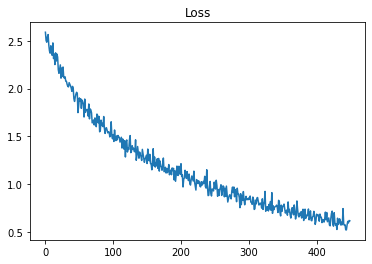

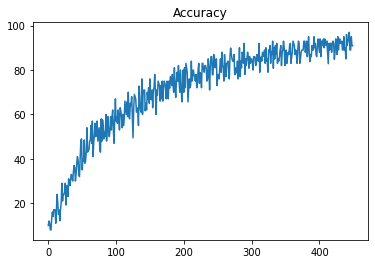

In [22]:
#@title Plotting Loss and Accuracy for ResNet18
plt.plot(loss_func)
plt.title("Loss")
plt.show()
plt.plot(accuracy)
plt.title("Accuracy")
plt.show()

In [23]:
#@title Checking Test Accuracy for ResNet18
for k, (img,lab) in enumerate(test):
    img = img.to(device)
    lab = lab.to(device)
    output = model(img)
    loss = criterion(output, lab)
    total = lab.size(0)
    _, predicted = torch.max(output.data , 1)
    correct = (predicted == lab).sum().item()
    acc = correct*100/total
    print(loss)
    print(acc)

tensor(1.5820, device='cuda:0', grad_fn=<NllLossBackward0>)
48.0
